<a href="https://colab.research.google.com/github/mottasilvia/TESIS/blob/main/I3D_prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook implementa un pipeline en PyTorch para la predicción de acciones en videos de handball utilizando dos modelos preentrenados del tipo I3D (Inflated 3D ConvNet): uno basado en imágenes RGB y otro basado en Optical Flow. El flujo del código está diseñado para realizar inferencias en intervalos de tiempo específicos dentro de un video y fusionar las predicciones de ambos modelos para obtener una clasificación de la acción detectada.

In [7]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 70.6 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=48948af31f433007841a3326790e339b0f8e182466b8811f0214787a313a96d5
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=ec1801b24bb8838faeda371a74a1d325924cc3b64bc762e65ed726da5f575ca9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel 

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import cv2
import numpy as np
from tqdm import tqdm

from torchvision import transforms
from PIL import Image

In [3]:
# Instalar OpenCV (si no está instalado, aunque generalmente ya viene preinstalado)
!pip install opencv-python-headless

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 13 15:06:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
### Carga los  modelos I3D
model_rgb = torch.load("/content/drive/MyDrive/UCU-TesisFinal/modelos/I3D/rgb_ana.pt")

model_optical_flow = torch.load("/content/drive/MyDrive/UCU-TesisFinal/modelos/I3D/optical_flow_ana.pt")

<ipython-input-8-a8641d41bc56>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_rgb = torch.load("/content/drive/MyDrive/UCU-TesisFinal/modelos/I3D/rgb_ana.pt")
<ipyth

In [ ]:
# Define the device -  'cuda' if a GPU is available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


**optical_flow** : Calcula el flujo óptico entre dos frames consecutivos.

In [16]:
import cv2
import numpy as np

# función para crear imagen de optical flow entre dos imágenes
def optical_flow(prev_frame, next_frame):

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Calcular el flujo óptico entre el frame anterior y el actual
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Convertir el flujo en ángulo y magnitud
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Crear una imagen HSV donde la dirección del flujo es codificada como color
    hsv = np.zeros_like(prev_frame)
    hsv[..., 1] = 255  # Saturación máxima
    hsv[..., 0] = angle * 180 / np.pi / 2  # Dirección del movimiento (Hue)
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Magnitud del movimiento (Value)

    # Convertir la imagen HSV a BGR para visualización o guardar
    bgr_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr_flow

In [12]:
import torch
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Configurar las transformaciones para los frames
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para realizar la inferencia en un video cada 2 segundos y mostrar ejemplos distribuidos uniformemente
def predict_video_interval(video_path, model_rgb, model_optical_flow, transform, frames_per_clip=16, interval_sec=2, device='cpu'):
    # Abrir el video
    cap = cv2.VideoCapture(video_path)

    # Obtener propiedades del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    print(f"Duration: {duration:.2f} seconds, FPS: {fps:.2f}")

    # Inicializar variables
    current_time = 0
    predictions = []

    while True:
        frames = []
        frames_optical_flow = []
        prev_frame = None

        # Saltar frames hasta el siguiente intervalo de tiempo
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

        # Leer frames para formar un clip
        for _ in range(frames_per_clip):
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_pil = Image.fromarray(frame_rgb)  # Convertir a PIL.Image
            frame_tensor = transform(frame_pil)  # Aplicar transformaciones
            frames.append((frame_tensor, frame_rgb))
            if prev_frame is not None:
              frame_flow = optical_flow(prev_frame, frame)
              frame_pil_flow = Image.fromarray(frame_flow)  # Convertir a PIL.Image
              frame_tensor_flow = transform(frame_pil_flow)  # Aplicar transformaciones
              frames_optical_flow.append((frame_tensor_flow, frame_flow))
            prev_frame = frame


        if len(frames) < frames_per_clip:
            break  # Salir si no hay suficientes frames para formar un clip

        # RGB
        # Separar frames en tensores y en imágenes RGB
        frames_tensor = torch.stack([f[0] for f in frames])
        frames_rgb = [f[1] for f in frames]

        # Reorganizar dimensiones del tensor
        frames_tensor = frames_tensor.unsqueeze(0)  # Añadir dimensión de batch
        frames_tensor = frames_tensor.permute(0, 2, 1, 3, 4)  # Reordenar a (B, C, T, H, W)

        # Optical Flow
        frames_optical_flow_tensor = torch.stack([f[0] for f in frames_optical_flow])
        frames_optical_flow_rgb = [f[1] for f in frames_optical_flow]

        frames_optical_flow_tensor = frames_optical_flow_tensor.unsqueeze(0)  # Añadir dimensión de batch
        frames_optical_flow_tensor = frames_optical_flow_tensor.permute(0, 2, 1, 3, 4)


        # Mover a la GPU si es necesario
        frames_tensor = frames_tensor.to(device)
        frames_optical_flow_tensor = frames_optical_flow_tensor.to(device)
        model_rgb = model_rgb.to(device)
        model_optical_flow = model_optical_flow.to(device)

        # Realizar la inferencia

        model_rgb.eval()
        model_optical_flow.eval()
        with torch.no_grad():

          outputs_rgb = model_rgb(frames_tensor) # logits
          _, preds_rgb = torch.max(outputs_rgb, 1) # predicciones
          rgb_probs = F.softmax(outputs_rgb, dim=1) # probabilidades
          #rgb_sorted_probs, rgb_sorted_indices = torch.sort(rgb_probs, dim=1, descending=True)

          outputs_optical_flow = model_optical_flow(frames_optical_flow_tensor)
          _, preds_optical_flow = torch.max(outputs_optical_flow, 1)
          optical_flow_probs = F.softmax(outputs_optical_flow, dim=1)
          #optical_flow_sorted_probs, optical_flow_sorted_indices = torch.sort(optical_flow_probs, dim=1, descending=True)

          # Promediar las predicciones
          final_probs = (rgb_probs + optical_flow_probs) / 2
          #final_sorted_probs, final_sorted_indices = torch.sort(final_probs, dim=1, descending=True)

        # Guardar las predicciones y los valores ordenados
        # predictions.append((current_time, sorted_probs.squeeze(), sorted_indices.squeeze(), frames_rgb))
        #predictions.append((current_time, rgb_sorted_probs, rgb_sorted_indices, optical_flow_sorted_probs, optical_flow_sorted_indices, final_sorted_probs, final_sorted_indices, frames_rgb, frames_optical_flow))
        predictions.append((current_time, rgb_probs, optical_flow_probs, final_probs, frames_rgb, frames_optical_flow))

        # Avanzar al siguiente intervalo de tiempo
        current_time += interval_sec

    cap.release()
    return predictions

# Función para mostrar 4 imágenes distribuidas uniformemente a lo largo del video
def display_images_uniformly(frames_rgb, time_sec, num_images = 4):
    total_frames = len(frames_rgb)
    indices = np.linspace(0, total_frames - 1, num_images).astype(int)  # Seleccionar índices uniformemente distribuidos

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames_rgb[indices[i]])
        ax.axis('off')
    plt.suptitle(f"Time: {time_sec:.2f} seconds", fontsize=16)
    plt.show()




In [13]:
class_names = ['crossing', 'jump-shot', 'otros', 'passing', 'shot']

In [17]:

# Define the device -  'cuda' if a GPU is available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta del nuevo video a evaluar

video_path ="/content/drive/MyDrive/UCU-TesisFinal/VIDEOS/Recortes/tiro2.mp4"
#video_path = "/content/drive/MyDrive/UCU-TesisFinal/VIDEOS/Escenas/Tiro_al_arco/vlc-record-2024-03-17-16h42m39s-1ra Fecha - Torneo Interligas - 2024.mp4-.mp4"

# Realizar la predicción en intervalos
predictions = predict_video_interval(video_path, model_rgb, model_optical_flow, transform, frames_per_clip=16, interval_sec=2, device=device)


Duration: 1.97 seconds, FPS: 30.00



Time: 0.00 seconds
4 shot


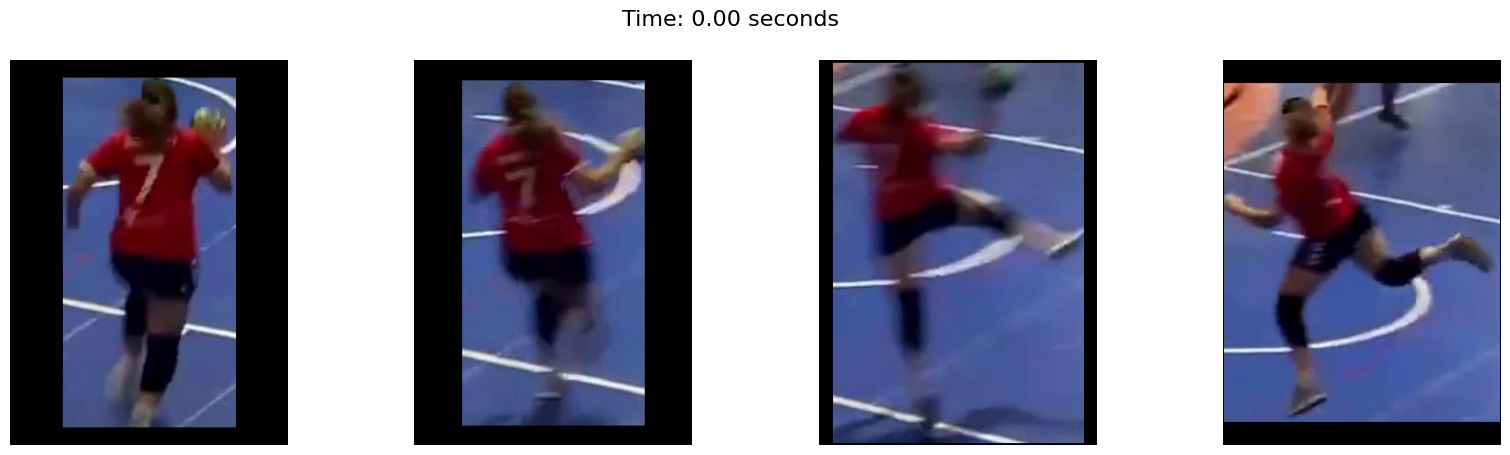

In [18]:
# Mostrar resultados
#class_names = train_dataset.classes  # Asumiendo que tienes el dataset de train cargado
for time_sec, rgb_sorted_probs, optical_flow_sorted_probs, final_sorted_probs, frames_rgb, frames_optical_flow in predictions:
    print(f"\nTime: {time_sec:.2f} seconds")
    m = torch.argmax(final_sorted_probs, dim=1)
    print(m.item(), class_names[m])
    #for i in range(len(rgb_sorted_probs[0])):
      #  print(f"{class_names[i]} | Final: {final_sorted_probs[0][i].item():.4f} RGB: {rgb_sorted_probs[0][i].item():.4f} Optical: {optical_flow_sorted_probs[0][i].item():.4f}")

    # Mostrar imágenes distribuidas uniformemente
    display_images_uniformly(frames_rgb, time_sec, 4)